In [1]:
%reset -sf

In [2]:
# Upgrade scikit
#!pip uninstall scikit-learn -y
!pip install -U scikit-learn

     |████████████████████████████████| 24.8 MB 882 kB/s            
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.5.0 which is incompatible.
hypertools 0.7.0 requires scikit-learn!=0.22,<0.24,>=0.19.1, but you have scikit-learn 1.0.2 which is incompatible.


In [3]:
# Patch Xeon Intel OneAPI Scikit accelerator
!pip install scikit-learn-intelex
from sklearnex import patch_sklearn
patch_sklearn()

     |████████████████████████████████| 69 kB 932 kB/s            
     |████████████████████████████████| 22.5 MB 1.7 MB/s            
     |████████████████████████████████| 284.3 MB 1.4 kB/s             
     |████████████████████████████████| 4.0 MB 52.5 MB/s            


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
from pathlib import Path
from pprint import pprint
from itertools import cycle
from random import randint
from random import randint
from itertools import cycle
from time import monotonic
from gc import collect
from joblib import dump, load as j_load

import matplotlib.pyplot as plt

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.multioutput import RegressorChain
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import sklearn.linear_model as ln
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, TimeSeriesSplit
from deap import creator as ga_cr, base as ga_b, algorithms as ga_algo, tools as ga_t

In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [6]:
path = Path().cwd().parent / 'input'
files = list(path.rglob('*'))
files

[PosixPath('/kaggle/input/tabular-playground-series-jan-2022'),
 PosixPath('/kaggle/input/tabular-playground-series-jan-2022/sample_submission.csv'),
 PosixPath('/kaggle/input/tabular-playground-series-jan-2022/train.csv'),
 PosixPath('/kaggle/input/tabular-playground-series-jan-2022/test.csv')]

In [7]:
train = pd.read_csv(files[2])
train['date'] = pd.to_datetime(train['date'], errors='coerce')
#train = train.set_index('date')

test = pd.read_csv(files[3])
test['date'] = pd.to_datetime(test['date'], errors='coerce')
#test = test.set_index('date')

train
test

,row_id,date,country,store,product,num_sold
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911
...,...,...,...,...,...,...
26293,26293,2018-12-31,Sweden,KaggleMart,Kaggle Hat,823
26294,26294,2018-12-31,Sweden,KaggleMart,Kaggle Sticker,250
26295,26295,2018-12-31,Sweden,KaggleRama,Kaggle Mug,1004
26296,26296,2018-12-31,Sweden,KaggleRama,Kaggle Hat,1441


,row_id,date,country,store,product
0,26298,2019-01-01,Finland,KaggleMart,Kaggle Mug
1,26299,2019-01-01,Finland,KaggleMart,Kaggle Hat
2,26300,2019-01-01,Finland,KaggleMart,Kaggle Sticker
3,26301,2019-01-01,Finland,KaggleRama,Kaggle Mug
4,26302,2019-01-01,Finland,KaggleRama,Kaggle Hat
...,...,...,...,...,...
6565,32863,2019-12-31,Sweden,KaggleMart,Kaggle Hat
6566,32864,2019-12-31,Sweden,KaggleMart,Kaggle Sticker
6567,32865,2019-12-31,Sweden,KaggleRama,Kaggle Mug
6568,32866,2019-12-31,Sweden,KaggleRama,Kaggle Hat


In [8]:
def pre_process(df):
    df = df.copy()
    #
    df['year'] = df['date'].dt.year
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['date'] = pd.to_datetime(df['date'])
    df['week']= df['date'].dt.week
    df['day'] = df['date'].dt.day
    df['dayofyear'] = df['date'].dt.dayofyear
    df['daysinmonth'] = df['date'].dt.days_in_month
    df['dayofweek'] = df['date'].dt.dayofweek
    df.loc[(df.date.dt.is_leap_year) & (df.dayofyear >= 60),'dayofyear'] -= 1
    df['weekend'] = (df['date'].dt.weekday >=5).astype(int)
    df['weekday'] = df['date'].dt.weekday
    #
    df['country'] = pd.Categorical(df['country']).codes
    df['store'] = pd.Categorical(df['store']).codes
    df['product'] = pd.Categorical(df['product']).codes
    #
    df = df.drop(columns=['date', 'row_id'])
    return df

train_ = pre_process(train)
test_ = pre_process(test)

train_
test_

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


,country,store,product,num_sold,year,quarter,month,week,day,dayofyear,daysinmonth,dayofweek,weekend,weekday
0,0,0,1,329,2015,1,1,1,1,1,31,3,0,3
1,0,0,0,520,2015,1,1,1,1,1,31,3,0,3
2,0,0,2,146,2015,1,1,1,1,1,31,3,0,3
3,0,1,1,572,2015,1,1,1,1,1,31,3,0,3
4,0,1,0,911,2015,1,1,1,1,1,31,3,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26293,2,0,0,823,2018,4,12,1,31,365,31,0,0,0
26294,2,0,2,250,2018,4,12,1,31,365,31,0,0,0
26295,2,1,1,1004,2018,4,12,1,31,365,31,0,0,0
26296,2,1,0,1441,2018,4,12,1,31,365,31,0,0,0


,country,store,product,year,quarter,month,week,day,dayofyear,daysinmonth,dayofweek,weekend,weekday
0,0,0,1,2019,1,1,1,1,1,31,1,0,1
1,0,0,0,2019,1,1,1,1,1,31,1,0,1
2,0,0,2,2019,1,1,1,1,1,31,1,0,1
3,0,1,1,2019,1,1,1,1,1,31,1,0,1
4,0,1,0,2019,1,1,1,1,1,31,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6565,2,0,0,2019,4,12,1,31,365,31,1,0,1
6566,2,0,2,2019,4,12,1,31,365,31,1,0,1
6567,2,1,1,2019,4,12,1,31,365,31,1,0,1
6568,2,1,0,2019,4,12,1,31,365,31,1,0,1


In [9]:
# Helpers

def lag_data(data, num_lags):
    """Create lagged features"""
    data = data.copy()
    lags = []
    for i in range(num_lags):
        lagged = data.shift(i+1).fillna(method='bfill')
        lags.append(lagged)
    data = pd.concat([data, *lags], axis=1)
    return data

def smape(y_true, y_pred):
    denominator = (y_true + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

In [10]:
class GA_Scikit():
    def __init__(self, 
                 estimator, 
                 #
                 params, 
                 eval_func, 
                 eval_weights, 
                 #
                 train_df, 
                 #valid_df, 
                 score, 
                 #
                 sel_tournsize=2, 
                 cx_uniform_prob=0.5, 
                 mut_shuffle_idx_prob=0.1, 
                 n_pop=30, 
                 n_gen=20, 
                 n_hof=1, 
                 cx_prob=0.5, 
                 mut_prob=0.1, 
                 n_jobs=1  # not good with HistGradBoosReg...
                ):
        
        self.est = estimator
        self.params = params
        self.eval_func = eval_func
        self.eval_weights = eval_weights
        #
        self.train_df = train_df
        #self.valid_df = valid_df
        self.score = score
        #
        self.sel_tournsize = sel_tournsize
        self.cx_uniform_prob = cx_uniform_prob
        self.mut_shuffle_idx_prob = mut_shuffle_idx_prob
        self.n_pop = n_pop
        self.n_gen = n_gen
        self.n_hof = n_hof
        self.cx_prob = cx_prob
        self.mut_prob = mut_prob
        self.n_jobs = n_jobs
        
        self._pad_params()
        self._create_fitness_and_indiv()
        self._register_indiv_and_pop_generators()
        self._register_eval_func()
        self._register_selection_crossover_mutation_methods()
        
    def _pad_params(self):
        """Pad params for crossover shuffle idx method"""
        assert isinstance(self.params, dict), 'Params must be a dict, i.e. estimator.get_params()'
        params_count = {k: len(v) for k,v in self.params.items()}
        max_length, max_key = -99, ''
        for k, v in params_count.items():
            if v <= max_length:
                continue
            else:
                max_key = k
                max_length = v
        assert isinstance(max_length, int), 'The max length between all params must be an int'
        # cycle through params for max length param, otherwise infinite cycle
        values_padded = (cycle(v) if k!=max_key else v for k,v in self.params.items())
        values_padded = zip(*values_padded)  # ('a', 1, 14), ('b', 2, 16), ('c', 3, 16) ...
        values_padded = zip(*values_padded)  # ('a', 'b', 'c'), (1, 2, 3), (14, 15, 16)...
        padded_params = {}
        for k, v in zip(self.params, values_padded):
            padded_params[k] = v
        self.padded_params = padded_params
        
    def _create_fitness_and_indiv(self):
        """Create GA individual and fitness entities (classes)"""
        ga_cr.create('Fitness', ga_b.Fitness, weights=self.eval_weights)
        ga_cr.create('Individual', list, fitness=ga_cr.Fitness)

    def _gen_params_to_ga(self):
        """Generate index for each param for individual"""
        max_dict = len(self.padded_params)
        max_length = len(list(self.padded_params.values())[0])
        idxs = [randint(0, max_length-1) for _ in range(max_dict)]
        return idxs
            
    def _register_indiv_and_pop_generators(self):
        """Register GA individual and population generators"""
        self.tb = ga_b.Toolbox()

        if self.n_jobs > 1:
            from multiprocessing import Pool
            pool = Pool()
            self.tb.register("map", pool.map)

        self.tb.register("individual", ga_t.initIterate, ga_cr.Individual, self._gen_params_to_ga)
        #print('indiv', self.tb.individual())
        self.tb.register("population", ga_t.initRepeat, list, self.tb.individual)
        #print('population', self.tb.population(n=2))
    
    def _register_eval_func(self):
        """Set GA evaluate individual function"""
        self.tb.register("evaluate",
                        self.eval_func,
                        padded_params=self.padded_params,
                        est=self.est,
                        train_df=self.train_df,
                        score=self.score
                        )
        #print(list(self.tb.evaluate(indiv) for indiv in self.tb.population(3)))
        
    def _register_selection_crossover_mutation_methods(self):
        """Register GA select/mate/mutate methods"""
        self.tb.register("select", ga_t.selTournament, tournsize=self.sel_tournsize)
        self.tb.register("mate", ga_t.cxUniform, indpb=self.cx_uniform_prob)
        self.tb.register("mutate", ga_t.mutShuffleIndexes, indpb=self.mut_shuffle_idx_prob)
        
    def run_ga_search(self):
        """Run search"""
        pop = self.tb.population(n=self.n_pop)
        hof = ga_t.HallOfFame(self.n_hof)

        # Stats stdout
        stats = ga_t.Statistics(lambda ind: ind.fitness.values )
        #stats1 = ga_t.Statistics(lambda ind: ind.fitness.values[0] )
        #stats2 = ga_t.Statistics(lambda ind: ind.fitness.values[1] )
        #stats3 = ga_t.Statistics(lambda ind: ind.fitness.values[2] )
        #stats4 = ga_t.Statistics(lambda ind: ind.fitness.values[2] )
        stats = ga_t.MultiStatistics(v_loss=stats)
        stats.register("avg", np.mean)
        #stats.register("std", np.std)
        #stats.register("min", np.min)
        #stats.register("max", np.max)
        
        
        # GA Run
        pop, log = ga_algo.eaSimple(pop, self.tb, cxpb=self.cx_prob, 
                                    mutpb=self.mut_prob, ngen=self.n_gen, 
                                    stats=stats, halloffame=hof, verbose=True)
        
        # Convert back params
        hof_ = {}
        for i in range(self.n_hof):
            hof_['hof_' + str(i)] = self._ga_to_params(hof[i])

        return pop, log, hof_
    
    def _ga_to_params(self, idx_params):
        """Helper to convert to readable params"""
        res = {}
        for (k,v), idx in zip(self.padded_params.items(), idx_params):
            res[k] = v[idx]
        return res

In [11]:
# Estimator, params and requirements

ts_est = HistGradientBoostingRegressor()

ts_params = {
            '#_lags': np.linspace(1, 20, 100).astype(int),
            #
            'loss': ['squared_error', 'absolute_error'],
            'learning_rate': np.linspace(.0001, .99, 100),
            'max_iter': np.linspace(2, 100, 100).astype(int),
            'max_leaf_nodes': np.linspace(2, 100, 100).astype(int),
            'max_depth': np.linspace(1, 100, 100).astype(int),
            'min_samples_leaf': np.linspace(2, 100, 100).astype(int),
            'l2_regularization': np.linspace(.0001, .99, 100),
            'max_bins': np.linspace(2, 255, 100).astype(int),
            'min_samples_leaf': np.linspace(2, 100, 100).astype(int),
            'tol': np.linspace(.01, 0.001, 100),
            'random_state': np.linspace(1, 100, 100).astype(int),
            }

def ts_eval_indiv(individual, padded_params, est, train_df, score):
    """Evaluate individual's genes (estimator's params)"""
    ### => Result tuple must match weights in GA
    data_params = {k : list(v)[idx] for (k,v), idx in zip(padded_params.items(), individual) if k == '#_lags'}
    train_X, train_y = train_df.drop('num_sold', axis=1), train_df['num_sold']
    train_X = lag_data(train_X, data_params['#_lags'])
    
    model_params = {k : list(v)[idx] for (k,v), idx in zip(padded_params.items(), individual) if k != '#_lags'}
    est.set_params(**model_params)  # seems can't parallelize this simultaneous with GA  # **{**model_params, **{'n_jobs': 1} }
    
    if True:
        ss = ShuffleSplit(n_splits=2, test_size=0.2)
        #ss = TimeSeriesSplit(n_splits=2)
        objs = []
        for train_idx, valid_idx in ss.split(train_X):
            #train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, train_size=0.8)

            est.fit(train_X.iloc[train_idx, :], train_y.iloc[train_idx])
            pred_v = est.predict(train_X.iloc[valid_idx, :])

            obj = score(train_y.iloc[valid_idx], pred_v)
            objs.append(obj)
            
        obj = np.mean(objs)
            
    else:
        # quick iterations
        train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, train_size=0.8)
        est.fit(train_X, train_y)
        pred_v = est.predict(valid_X)
        obj = score(valid_y, pred_v)
    
    collect()
    
    return obj,
        
ts_weights = -1,

In [12]:
ga_params = GA_Scikit(ts_est,  # TODO try others
                      ts_params,
                      ts_eval_indiv,
                      ts_weights,
                      #
                      train_,
                      smape,
                      )
pop, log, hof = ga_params.run_ga_search()

   	      	        v_loss        
   	      	----------------------
gen	nevals	avg    	gen	nevals
0  	30    	8.16724	0  	30    
1  	18    	6.02932	1  	18    
2  	22    	5.90482	2  	22    
3  	22    	5.58115	3  	22    
4  	15    	5.43133	4  	15    
5  	16    	5.25688	5  	16    
6  	16    	5.44704	6  	16    
7  	22    	5.10524	7  	22    
8  	16    	5.05662	8  	16    
9  	18    	5.13435	9  	18    
10 	10    	4.93676	10 	10    
11 	10    	4.91668	11 	10    
12 	21    	4.96789	12 	21    
13 	11    	4.90564	13 	11    
14 	21    	4.89055	14 	21    
15 	17    	4.87024	15 	17    
16 	15    	4.85796	16 	15    
17 	16    	4.81245	17 	16    
18 	16    	4.82211	18 	16    
19 	16    	4.97   	19 	16    
20 	17    	4.77468	20 	17    


In [18]:
hof

{'hof_0': {'#_lags': 2,
  'loss': 'squared_error',
  'learning_rate': 0.2900707070707071,
  'max_iter': 60,
  'max_leaf_nodes': 52,
  'max_depth': 86,
  'min_samples_leaf': 7,
  'l2_regularization': 0.590040404040404,
  'max_bins': 224,
  'tol': 0.009000000000000001,
  'random_state': 32}}

In [14]:
# Save best model

ts_est = HistGradientBoostingRegressor()
model_params = {k:v for k,v in hof['hof_0'].items() if k != '#_lags'}
_ = ts_est.set_params(**model_params)
dump(ts_est, 'best_model.joblib')

['best_model.joblib']

In [15]:
# Load saved model

ts_est = j_load('best_model.joblib')
ts_est

HistGradientBoostingRegressor(l2_regularization=0.590040404040404,
                              learning_rate=0.2900707070707071, max_bins=224,
                              max_depth=86, max_iter=60, max_leaf_nodes=52,
                              min_samples_leaf=7, random_state=32,
                              tol=0.009000000000000001)

HistGradientBoostingRegressor(l2_regularization=0.590040404040404,
                              learning_rate=0.2900707070707071, max_bins=224,
                              max_depth=86, max_iter=60, max_leaf_nodes=52,
                              min_samples_leaf=7, random_state=32,
                              tol=0.009000000000000001)

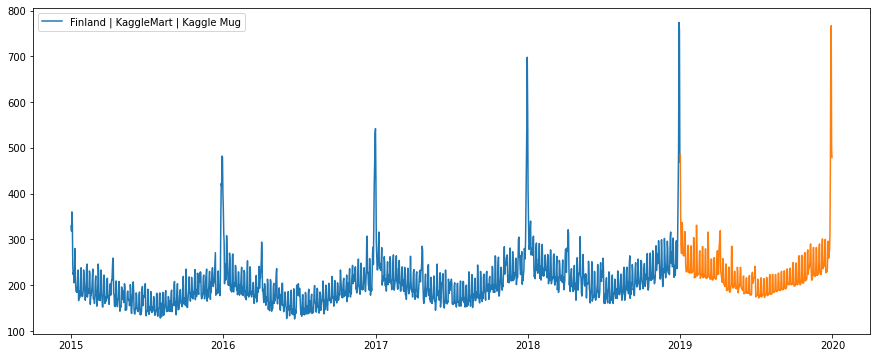

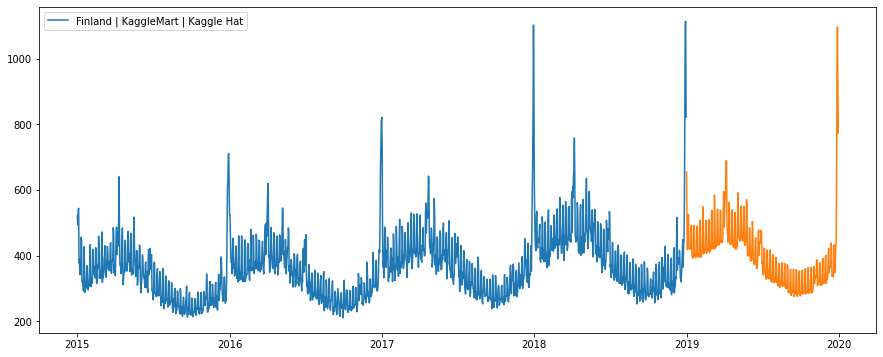

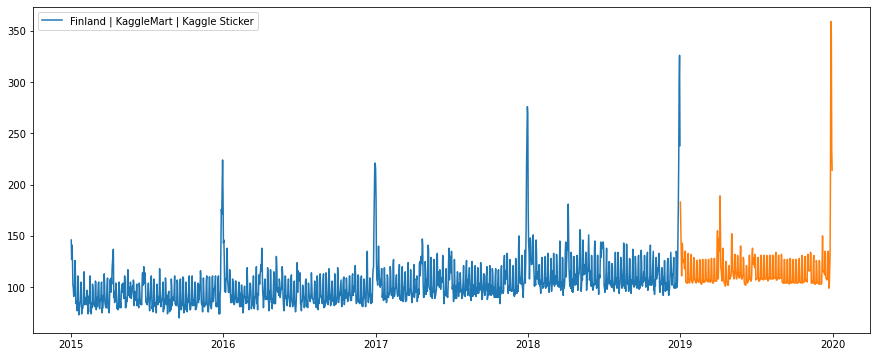

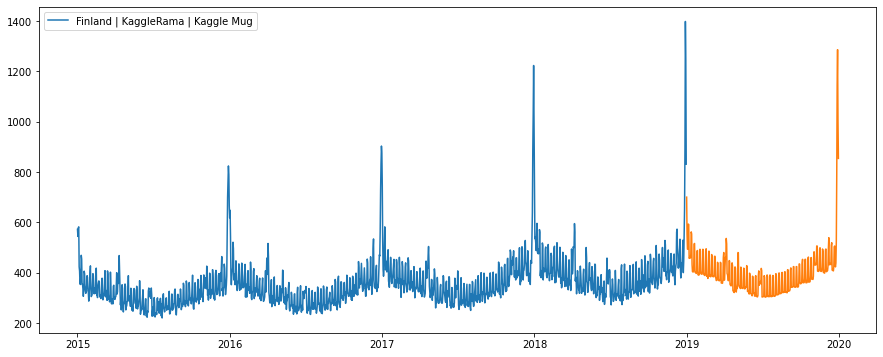

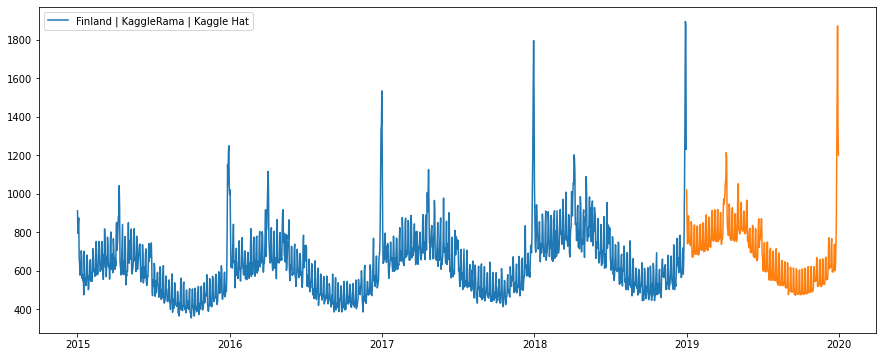

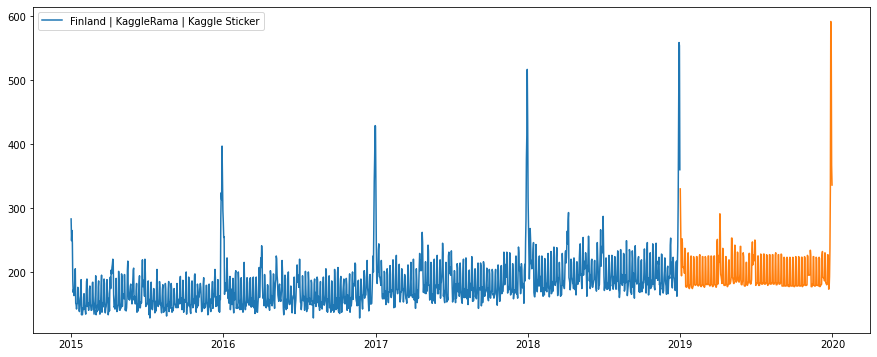

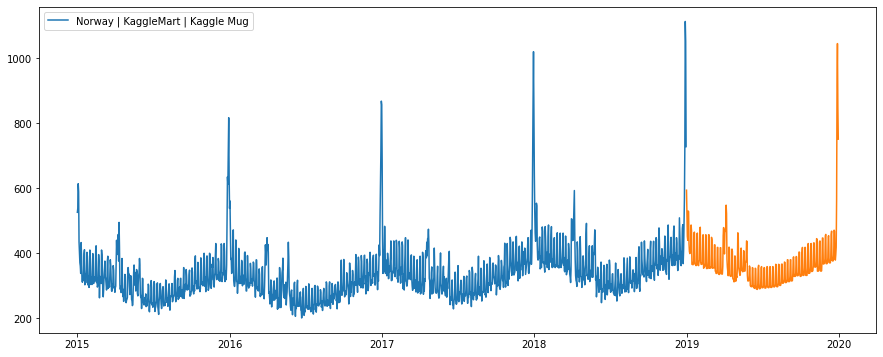

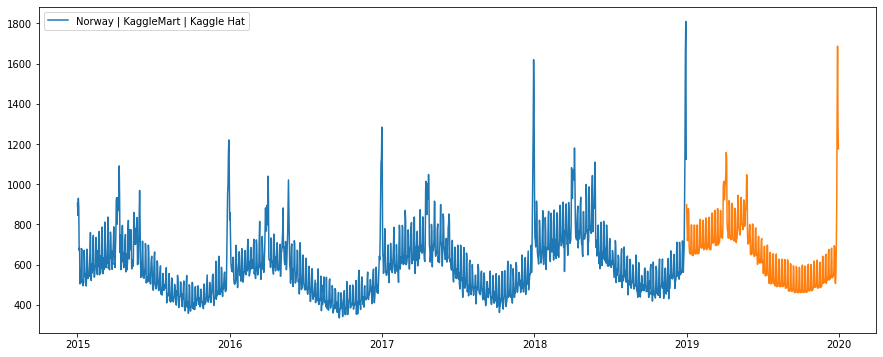

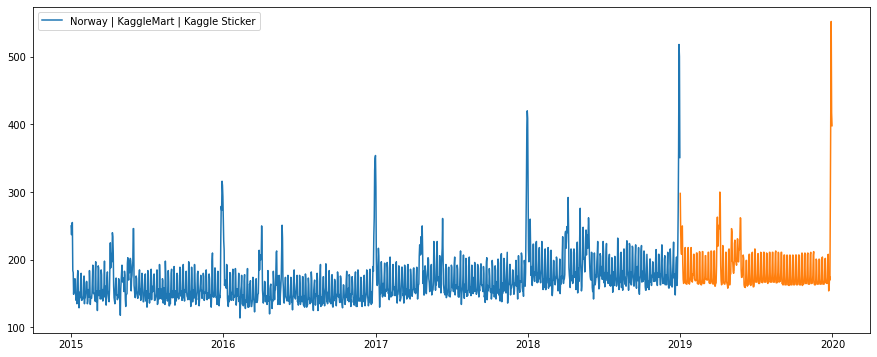

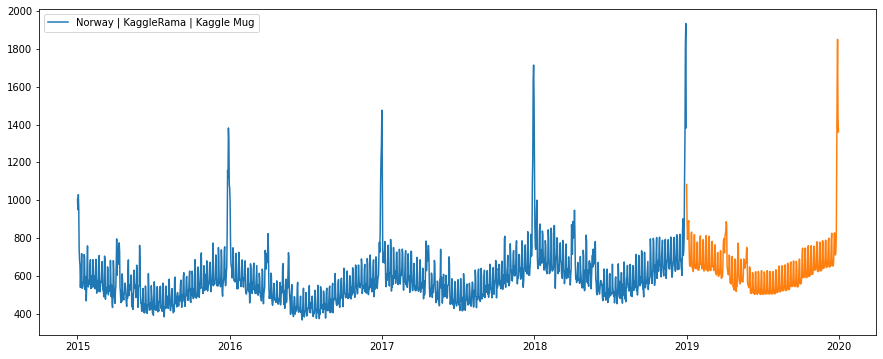

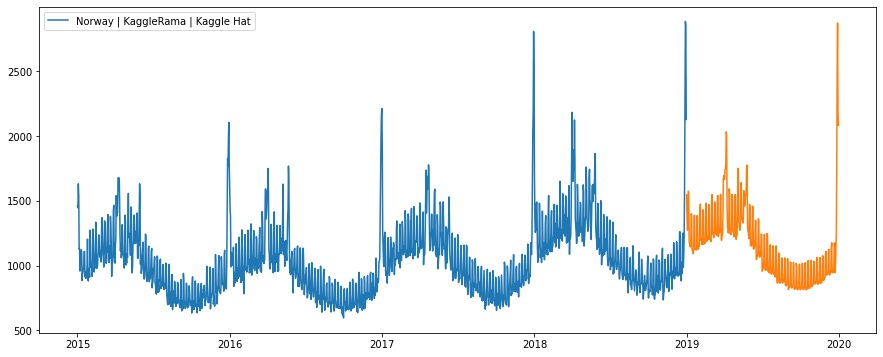

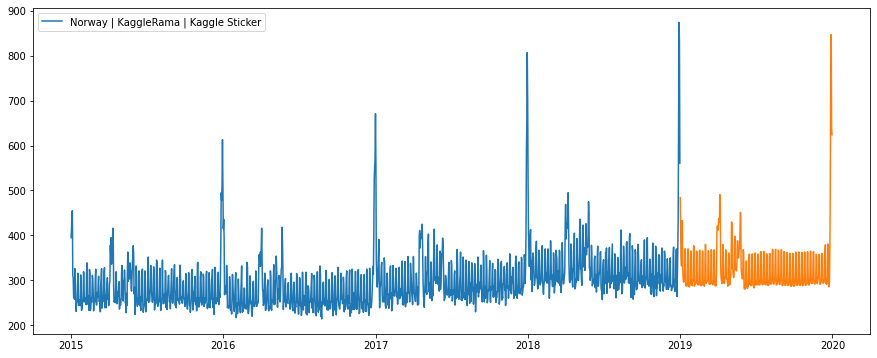

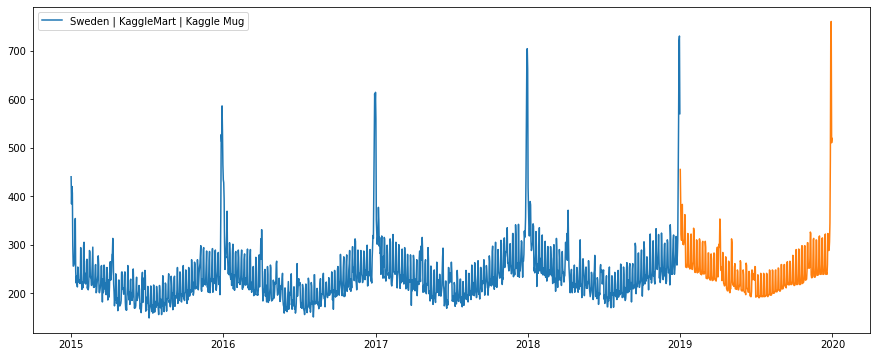

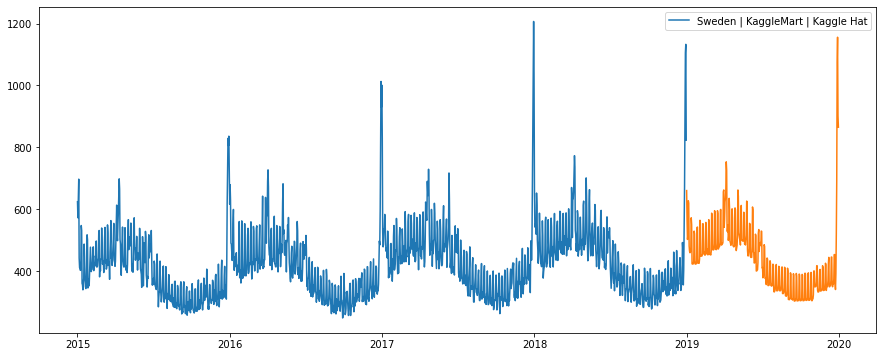

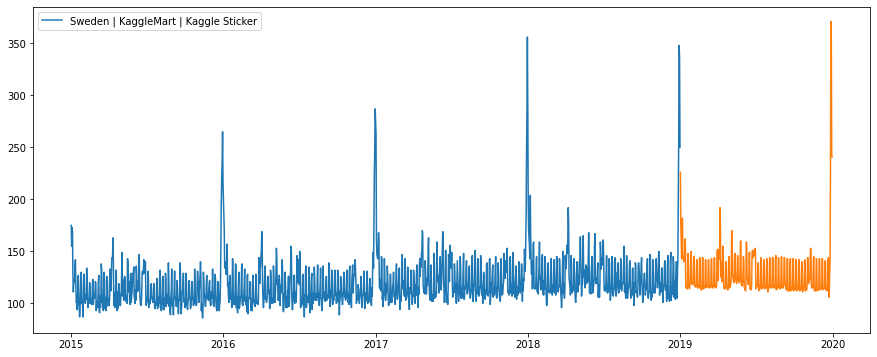

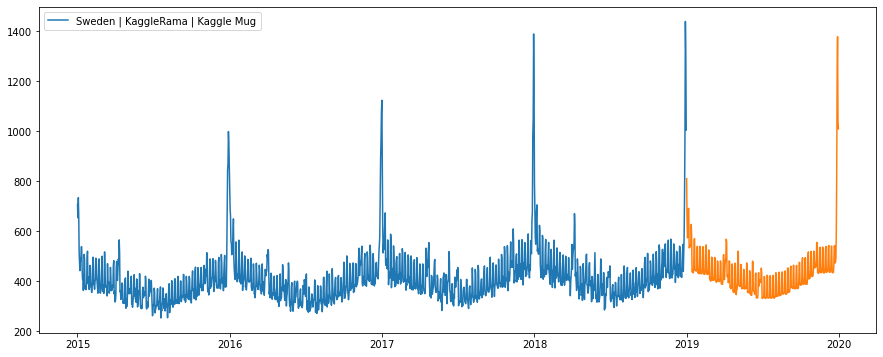

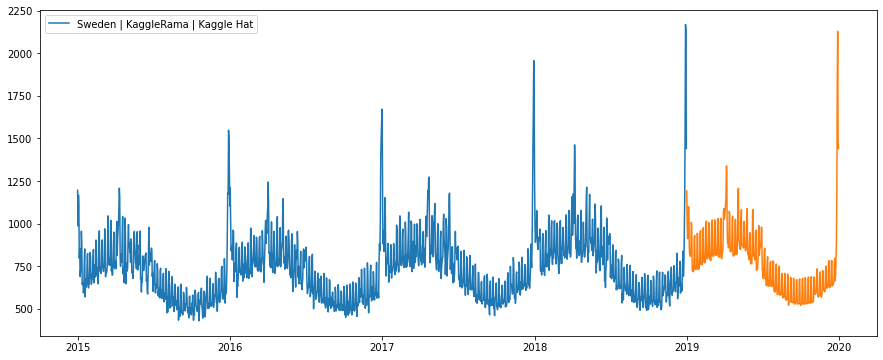

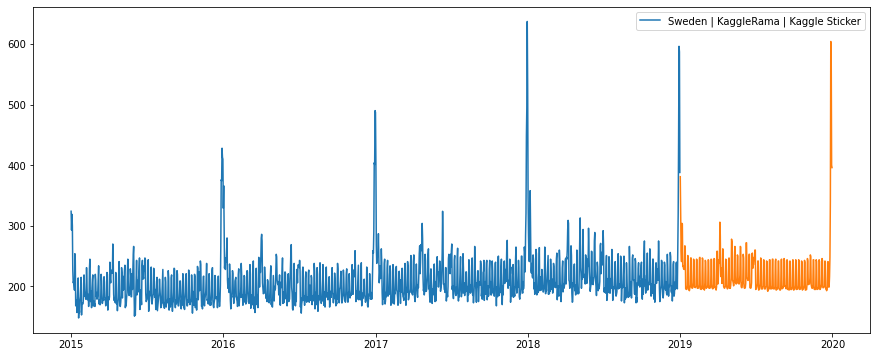

In [16]:
# Forecast and see

# Full data
train_X, train_y = train_.drop('num_sold', axis=1), train_['num_sold']

data_params = {k:v for k,v in hof['hof_0'].items() if k == '#_lags'}
train_X = lag_data(train_X, data_params['#_lags'])
test__ = lag_data(test_, data_params['#_lags'])

# Fit and forecast
ts_est.fit(train_X, train_y)
forec = ts_est.predict(test__).astype(int)
test['num_sold'] = forec

# Vis
train['type'] = 'train'
test['type'] = 'test'

temp = train.append(test)
for c in temp['country'].unique():
    for s in temp['store'].unique():
        for p in temp['product'].unique():
            fig, ax = plt.subplots(figsize=(15,6))
            mask = (temp['country']==c) & (temp['store']==s) & (temp['product']==p)
            sub = temp[mask]
            sub = sub.set_index('date')
            sub_ = sub['num_sold'][sub['type']=='train']
            _ = ax.plot(sub_, label=f'{c} | {s} | {p}')
            sub_ = sub['num_sold'][sub['type']=='test']
            _ = ax.plot(sub_)
            _ = ax.legend()
            plt.show()
            plt.clf()
            plt.close()

In [17]:
# Submission
test = test[['row_id', 'num_sold']]
test.to_csv('submission.csv', index=False)
test

,row_id,num_sold
0,26298,486
1,26299,655
2,26300,183
3,26301,700
4,26302,1019
...,...,...
6565,32863,865
6566,32864,241
6567,32865,1009
6568,32866,1441
